In [47]:
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
import arviz as az
import pytensor.tensor as tt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU

In [41]:
# Define constants
SIZE = 200
NUM_SAMPLES = 10
EPOCHS = 10

In [122]:
def sim_channel(params):
    #print("sim_channel")
    To, Tc, Anoise, Fnoise, scale, offset = params
    t = np.arange(SIZE)
    channel = np.random.choice([0, 1], size=SIZE, p=[1-To, To])
    # Extract the numerical value from Anoise if it's an xarray.DataArray
    A = tt.random.normal(0, Anoise, SIZE)   
    F = tt.sin(2 * np.pi * t)*Fnoise
    
    #Make the correct shape before stacking!
    offsets = np.ones((SIZE,))*offset
    scaled = channel*scale
    noisy = scaled+offsets+A+F
    #print("scaled shape",scaled.shape)
    #print("noisy shape", noisy.eval().shape)
    return np.stack([channel, noisy.eval()], axis=-1)

In [123]:
#TEST
orig_params = [0.1, 1e-6, 0.01, 0.01, 0.25, -0.5]
strip = sim_channel(orig_params)

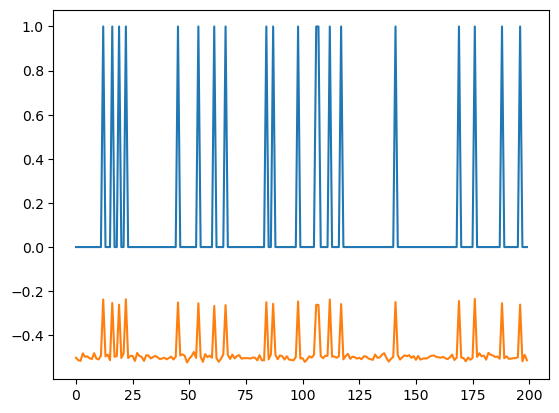

In [124]:
plt.plot(strip)
plt.show()

In [125]:
# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (SIZE // 4), 1)
        )

    def forward(self, x):
        return self.model(x.permute(0, 2, 1))

In [126]:
# Loss function for the discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [127]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [130]:
# Generate some fake "real" data for demonstration
real_data = torch.tensor([sim_channel(orig_params) for _ in range(NUM_SAMPLES)], dtype=torch.float32)

In [131]:
# Define the Bayesian model
with pm.Model() as model:
    # Priors for parameters
    To = pm.Beta('To', alpha=2, beta=5)
    Tc = pm.Beta('Tc', alpha=2, beta=5)
    Anoise = pm.HalfNormal('Anoise', sigma=0.1)
    Fnoise = pm.HalfNormal('Fnoise', sigma=0.1)
    scale = pm.HalfNormal('scale', sigma=0.5)
    offset = pm.Normal('offset', mu=0, sigma=0.1)
    
    # Define a Deterministic variable for the synthetic data
    def generate_synthetic_data(To, Tc, Anoise, Fnoise, scale, offset):
        t = tt.arange(SIZE)
        channel = tt.cast(tt.random.binomial(n=1, p=To, size=SIZE), 'float32')
        A = tt.random.normal(0, Anoise, SIZE)
        F = tt.sin(2 * np.pi * t)*Fnoise
        noise =  A + F 
        return tt.stack([channel, channel * scale + offset + noise], axis=-1)
    
    synthetic_data = pm.Deterministic('synthetic_data', 
                                      generate_synthetic_data(To, Tc, Anoise, Fnoise, scale, offset))
    
    # Placeholder for discriminator feedback (will be updated during training)
    discriminator_output = pm.MutableData('discriminator_output', value=0)

    # Likelihood (we want the discriminator to output close to 1 for generated data)
    pm.Normal('likelihood', mu=discriminator_output, sigma=0.1, observed=1)

In [132]:
# Training loop
for epoch in tqdm(range(EPOCHS)):
    # Sample from the posterior
    with model:
        trace = pm.sample(500, tune=500, chains=2, cores=1)
    
    # Generate synthetic data using the samples
    synthetic_data = []
    for i in range(NUM_SAMPLES):
        idx = np.random.randint(len(trace))
        posterior = trace.posterior.stack(sample=['chain', 'draw']) 
        iTo = posterior['To'][idx].values
        iTc = posterior['Tc'][idx].values
        iAnoise = posterior['Anoise'][idx].values
        iFnoise = posterior['Fnoise'][idx].values
        iscale = posterior['scale'][idx].values
        ioffset = posterior['offset'][idx].values
        
        params = [iTo, iTc, iAnoise, iFnoise, iscale, ioffset]
        strip = sim_channel(params)
        synthetic_data.append(torch.tensor(strip, dtype=torch.float32))
    synthetic_data = torch.stack(synthetic_data)
    
    # Train the discriminator
    real_output = discriminator(real_data)
    fake_output = discriminator(synthetic_data)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()

    # Update the model's posterior using the discriminator's feedback
    with model:
        pm.set_data({'discriminator_output': fake_output.mean().item()})
    clear_output(wait=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.43s/it]


array([[<Axes: title={'center': 'offset'}>,
        <Axes: title={'center': 'offset'}>],
       [<Axes: title={'center': 'To'}>, <Axes: title={'center': 'To'}>],
       [<Axes: title={'center': 'Tc'}>, <Axes: title={'center': 'Tc'}>],
       [<Axes: title={'center': 'Anoise'}>,
        <Axes: title={'center': 'Anoise'}>],
       [<Axes: title={'center': 'Fnoise'}>,
        <Axes: title={'center': 'Fnoise'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'synthetic_data'}>,
        <Axes: title={'center': 'synthetic_data'}>]], dtype=object)

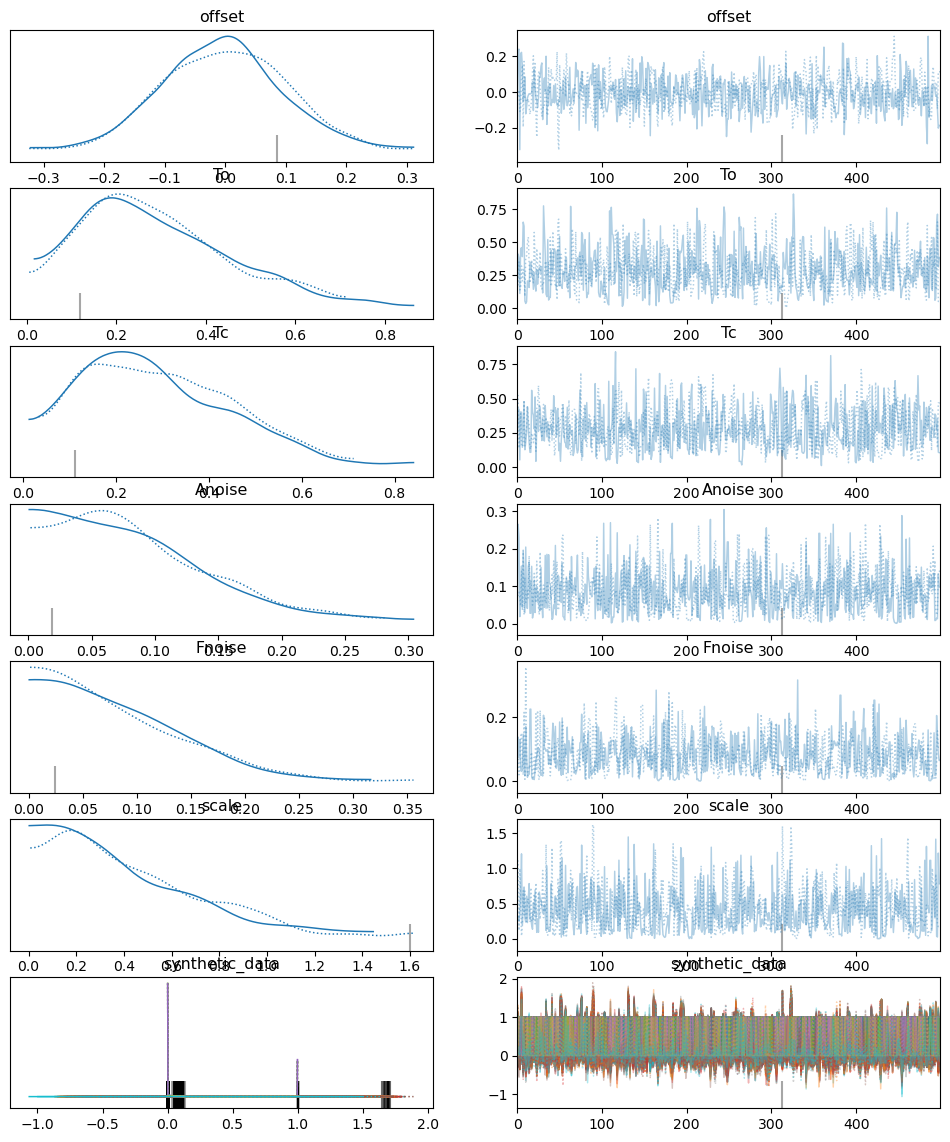

In [133]:
az.plot_trace(trace)

In [134]:
summary = az.summary(trace)
print(summary)

                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
offset                 -0.003  0.097  -0.195    0.165      0.003    0.003   
To                      0.289  0.162   0.042    0.602      0.006    0.004   
Tc                      0.288  0.153   0.040    0.564      0.006    0.004   
Anoise                  0.085  0.060   0.001    0.193      0.002    0.001   
Fnoise                  0.082  0.061   0.001    0.188      0.002    0.002   
...                       ...    ...     ...      ...        ...      ...   
synthetic_data[197, 1]  0.112  0.292  -0.336    0.742      0.009    0.007   
synthetic_data[198, 0]  0.296  0.457   0.000    1.000      0.015    0.010   
synthetic_data[198, 1]  0.123  0.297  -0.297    0.770      0.010    0.007   
synthetic_data[199, 0]  0.273  0.446   0.000    1.000      0.014    0.010   
synthetic_data[199, 1]  0.113  0.298  -0.335    0.774      0.011    0.008   

                        ess_bulk  ess_tail  r_hat  
offset                 

In [135]:
# Extracting parameter names
parameter_names = summary.index.tolist()

# Iterating through parameter names
params=[]
for i, param in enumerate(parameter_names):
    mean_value = summary.loc[param, 'mean']
    params.append(mean_value)
    print(f"Parameter: {param}, Mean: {mean_value}")
    if i >= 5:
        break

Parameter: offset, Mean: -0.003
Parameter: To, Mean: 0.289
Parameter: Tc, Mean: 0.288
Parameter: Anoise, Mean: 0.085
Parameter: Fnoise, Mean: 0.082
Parameter: scale, Mean: 0.42


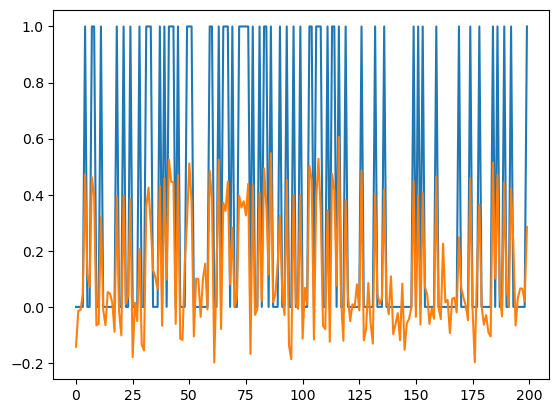

In [138]:
plt.plot(sim_channel([params[1],params[2],params[3],params[4],params[5],params[0]]))
plt.show()

In [ ]:
#So runs but stupidly unrealistic models!

In [61]:
import tensorflow_probability as tfp

def sim_channel(params):
    # ([To, Tc1, Anoise, Fnoise, scale, offset, nSpikes, Tc2, To2])
    To, Tc1, Anoise, Fnoise, SCALE, OFFSET, nSpikes, Tc2, To2 = params
    #nE = tf.cast(nE, dtype=tf.int32)
    nSpikes = tf.cast(nSpikes, dtype=tf.int32)
    t = tf.range(0, T, dtype=tf.float32) * dt
    zero = tf.constant(0.0, dtype=tf.float32)
    row1 = tf.stack([zero, Tc2, zero])
    row2 = tf.stack([Tc1, zero, To])
    row3 = tf.stack([zero, Tc1, zero])
    row4 = tf.stack([zero,zero,To2,zero])
    r1 = tf.reduce_sum(row1)
    row1 = tf.stack([1-r1, Tc2, zero])
    r2 = tf.reduce_sum(row2)
    row2 = tf.stack([Tc1, 1-r2, To])
    r3 = tf.reduce_sum(row3)
    row3 = tf.stack([zero, Tc1, 1-r3])
    r4 = tf.reduce_sum(row4)
    row4 = tf.stack([zero, zero, To2, 1-r4]) 
    transition_matrix = tf.stack([row1, row2, row3])
    
    # Define the transition function
    # This function uses tf.gather to select the correct row of the transition matrix
    transition_fn = lambda _, state: tfp.distributions.Categorical(
        probs=tf.gather(transition_matrix, state))  
    
    # Define the initial state distribution
    initial_distribution = tfp.distributions.Categorical(probs=[0.3, 0.3, 0.2, 0.2])
    
    # Define the Markov chain
    markov_chain = tfp.distributions.MarkovChain(
        initial_state_prior=initial_distribution,
        transition_fn=transition_fn,
        num_steps=T  # Number of steps to simulate
    )

    # Sample from the Markov chain
    channels = markov_chain.sample()

    channels = tf.where(tf.less(channels, 2), tf.zeros_like(channels), tf.ones_like(channels))

In [60]:
import torch
import torch.nn.functional as F
import pymc as pm
import numpy as np

def sim_channel(params, T, dt):
    To, Tc1, Anoise, Fnoise, SCALE, OFFSET, nSpikes, Tc2, To2 = params
    nSpikes = int(nSpikes)
    t = torch.arange(0, T, dt)
    zero = torch.tensor(0.0)
    
    # Convert parameters to tensors
    Tc2 = torch.tensor(Tc2)
    Tc1 = torch.tensor(Tc1)
    To = torch.tensor(To)
    To2 = torch.tensor(To2)
    
    row1 = torch.stack([zero, Tc2, zero])
    row2 = torch.stack([Tc1, zero, To])
    row3 = torch.stack([zero, Tc1, zero])
    row4 = torch.stack([zero, zero, To2, zero])
    
    r1 = torch.sum(row1)
    row1 = torch.stack([1-r1, Tc2, zero])
    r2 = torch.sum(row2)
    row2 = torch.stack([Tc1, 1-r2, To])
    r3 = torch.sum(row3)
    row3 = torch.stack([zero, Tc1, 1-r3])
    r4 = torch.sum(row4)
    row4 = torch.stack([zero, zero, To2, 1-r4])
    
    transition_matrix = torch.stack([row1, row2, row3])
    
    # Define the transition function
    def transition_fn(state):
        probs = transition_matrix[state]
        return torch.distributions.Categorical(probs=probs).sample()
    
    # Define the initial state distribution
    initial_probs = torch.tensor([0.3, 0.3, 0.2, 0.2])
    initial_distribution = torch.distributions.Categorical(probs=initial_probs)
    
    # Define the Markov chain
    states = [initial_distribution.sample().item()]
    for _ in range(T - 1):
        states.append(transition_fn(states[-1]).item())
    
    channels = torch.tensor(states)
    channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
    
    return channels

# Example usage
params = [0.1, 0.2, 0.3, 0.4, 1.0, 0.0, 10, 0.5, 0.6]
T = 100
dt = 0.01
channels = sim_channel(params, T, dt)
print(channels)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1])
